In [15]:
import pandas as pd
import pickle
from tqdm import tqdm
import random
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [10]:
def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
# read datasets

# CRISPR/RNAi
ge_matrix = pickle.load(open('../general_datasets/ge_matrix.pkl', 'rb'))

# CRISPR和RNAi分别的所有gene
genes_all_key = {}
genes_all_key['CRISPR'] = list(ge_matrix['CRISPR'].columns)
genes_all_key['RNAi'] = list(ge_matrix['RNAi'].columns)

# ge_cut
ge_cut = {}
ge_cut['CRISPR'] = -0.237
ge_cut['RNAi'] = -0.325

seeds = [0,42,100,1000,10000,100000,1000000,10000000,100000000,1000000000]

ft_posi_seed_key = pickle.load(open('PCorr_PPI_datasets/ft_posi_seed_key.pkl', 'rb'))
ft_nega_seed_key = pickle.load(open('PCorr_PPI_datasets/ft_nega_seed_key.pkl', 'rb'))

##### 1. PCorr signals of BioGRID-derived PPIs

In [ ]:
# ppis of each experiment in BioGRID
db = pd.read_table('PCorr_PPI_datasets/BIOGRID-ORGANISM-Homo_sapiens-4.4.242.tab3.txt')
db = db[['Official Symbol Interactor A','Official Symbol Interactor B','Experimental System',
         'Experimental System Type','Organism Name Interactor A','Organism Name Interactor B']]

db.columns = ['gene_1','gene_2','experiment','experiment_type','organism_1','organism_2']

db_human = db[(db['organism_1'] == 'Homo sapiens')&(db['organism_2'] == 'Homo sapiens')]

ex_ppi = {}
for i in tqdm(db_human.index):
    ex = db_human['experiment'][i]
    g1 = db_human['gene_1'][i]
    g2 = db_human['gene_2'][i]
    ppi = sorted([g1,g2])
    try:
        ex_ppi[ex].add((ppi[0],ppi[1]))
    except:
        ex_ppi[ex] = set()
        ex_ppi[ex].add((ppi[0], ppi[1]))

# Extraction of feature matrices
ft_biogrid_key_ex = {}
for ex in tqdm(ex_ppi.keys()):
    ft_biogrid_key_ex[ex] = {}
    
    ppis = ex_ppi[ex]
    for ge_key in ['CRISPR', 'RNAi']:
        genes_all = genes_all_key[ge_key]
        ppis_list = []
        ft_all_list = []
        for ppi in ppis:
            ppi_lst = sorted(list(ppi))
            g1 = ppi_lst[0]
            g2 = ppi_lst[1]
            if g1 in genes_all and g2 in genes_all:
                ge_1 = ge_matrix_dict[ge_key][g1].dropna()
                ge_2 = ge_matrix_dict[ge_key][g2].dropna()

                ge_f_1 = ge_1[ge_1 < ge_cut[ge_key]]
                ge_f_2 = ge_2[ge_2 < ge_cut[ge_key]]

                ccls_inter = list(set(ge_f_1.index) & set(ge_f_2.index))
                ge_final_1 = ge_f_1[ccls_inter]
                ge_final_2 = ge_f_2[ccls_inter]

                if len(ccls_inter) >= 10:
                    # pearson相关性系数
                    pearson_r = pearsonr(ge_final_1, ge_final_2)

                    pearson_coeff = pearson_r[0]
                    pearson_p = pearson_r[1]

                    # ols模型
                    X_with_intercept = sm.add_constant(ge_final_1)
                    model_ols = sm.OLS(ge_final_2, X_with_intercept)
                    ols_r = model_ols.fit()

                    ols_coeff_0 = ols_r.params[0]
                    ols_se_0 = ols_r.bse[0]

                    ols_coeff_1 = ols_r.params[1]
                    ols_se_1 = ols_r.bse[1]

                    g1_essen = math.sqrt(
                        np.sum([np.power((i - 0), 2) for i in ge_final_1]))
                    g2_essen = math.sqrt(
                        np.sum([np.power((i - 0), 2) for i in ge_final_2]))

                    g1_mean = np.mean(ge_final_1)
                    g2_mean = np.mean(ge_final_2)
                    g1_std = np.std(ge_final_1)
                    g2_std = np.std(ge_final_2)

                    g1_min = min(ge_final_1)
                    g1_25 = np.percentile(ge_final_1, 25)
                    g1_50 = np.percentile(ge_final_1, 50)
                    g1_75 = np.percentile(ge_final_1, 75)
                    g1_max = max(ge_final_1)

                    g2_min = min(ge_final_2)
                    g2_25 = np.percentile(ge_final_2, 25)
                    g2_50 = np.percentile(ge_final_2, 50)
                    g2_75 = np.percentile(ge_final_2, 75)
                    g2_max = max(ge_final_2)

                    ge_e_1 = []
                    for k in ge_1:
                        if k > 0:
                            ge_e_1.append(0)
                        else:
                            ge_e_1.append(k)

                    ge_e_2 = []
                    for k in ge_2:
                        if k > 0:
                            ge_e_2.append(0)
                        else:
                            ge_e_2.append(k)

                    g1_essen_all = math.sqrt(
                        np.sum([np.power((i - 0), 2) for i in ge_e_1]))
                    g2_essen_all = math.sqrt(
                        np.sum([np.power((i - 0), 2) for i in ge_e_2]))

                    g1_mean_all = np.mean(ge_e_1)
                    g2_mean_all = np.mean(ge_e_2)
                    g1_std_all = np.std(ge_e_1)
                    g2_std_all = np.std(ge_e_2)

                    g1_min_all = min(ge_e_1)
                    g1_25_all = np.percentile(ge_e_1, 25)
                    g1_50_all = np.percentile(ge_e_1, 50)
                    g1_75_all = np.percentile(ge_e_1, 75)
                    g1_max_all = max(ge_e_1)

                    g2_min_all = min(ge_e_2)
                    g2_25_all = np.percentile(ge_e_2, 25)
                    g2_50_all = np.percentile(ge_e_2, 50)
                    g2_75_all = np.percentile(ge_e_2, 75)
                    g2_max_all = max(ge_e_2)

                    features = [len(ccls_inter), pearson_coeff, pearson_p,
                                ols_coeff_0, ols_se_0,
                                ols_coeff_1, ols_se_1,
                                g1_essen, g2_essen,
                                g1_essen_all, g2_essen_all,
                                g1_mean, g2_mean, g1_std, g2_std,
                                g1_25, g1_50, g1_75, g2_25, g2_50, g2_75,
                                g1_min, g2_min, g1_max, g2_max,
                                g1_mean_all, g2_mean_all, g1_std_all, g2_std_all,
                                g1_25_all, g1_50_all, g1_75_all, g2_25_all, g2_50_all, g2_75_all,
                                g1_min_all, g2_min_all, g1_max_all, g2_max_all,
                                ]
                    ppis_list.append(ppi)
                    ft_all_list.append(features)

        ft_biogrid_key_ex[ex][ge_key] = pd.DataFrame(ft_all_list, index=ppis_list,
                                                     columns=['SCCLs_number', 'pearson_coeff', 'pearson_p',
                                                              'ols_coeff_0', 'ols_se_0',
                                                              'ols_coeff_1', 'ols_se_1',
                                                              'g1_essen', 'g2_essen',
                                                              'g1_essen_all', 'g2_essen_all',
                                                              'g1_mean', 'g2_mean', 'g1_std', 'g2_std',
                                                              'g1_25', 'g1_50', 'g1_75', 'g2_25', 'g2_50', 'g2_75',
                                                              'g1_min', 'g2_min', 'g1_max', 'g2_max',
                                                              'g1_mean_all', 'g2_mean_all', 'g1_std_all', 'g2_std_all',
                                                              'g1_25_all', 'g1_50_all', 'g1_75_all', 'g2_25_all', 'g2_50_all',
                                                              'g2_75_all',
                                                              'g1_min_all', 'g2_min_all', 'g1_max_all', 'g2_max_all',
                                                              ])

# PCorr-PPI scores of BioGRID-derived PPIs grouped by experiment
r_biogrid_key_ex = {}
for ex in tqdm(ft_ex.keys()):
    r_biogrid_key_ex[ex] = {}
    for ge_key in ['CRISPR', 'RNAi']:
        ft = ft_biogrid_key_ex[ex][ge_key]
        if ft.empty == False:
            if ge_key == 'CRISPR':
                rf = RandomForestClassifier(random_state=42,
                                            n_estimators=300, max_features='sqrt', max_depth=15,
                                            min_samples_split=9, min_samples_leaf=4)
            else:
                rf = RandomForestClassifier(random_state=42,
                                            n_estimators=300, max_features='sqrt', max_depth=15,
                                            min_samples_split=8, min_samples_leaf=3)

            X_data = np.array(ft, dtype='float32')

            ft_posi_seed = ft_posi_seed_key[ge_key]
            ft_nega_seed = ft_nega_seed_key[ge_key]

            for s in seeds:
                ft_posi = ft_posi_seed[s]
                ft_posi['label'] = [1] * len(ft_posi)
                ft_nega = ft_nega_seed[s]
                ft_nega['label'] = [0] * len(ft_nega)

                ft_seed = pd.concat([ft_posi, ft_nega], axis=0)

                X = np.array(ft_seed.iloc[:, :-1], dtype='float32')
                y = np.array(ft_seed.iloc[:, [-1]], dtype='float32')
                X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
                X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

                rf.fit(X_train, y_train)

                y_probs = rf.predict_proba(X_data)[:, 1]
                ft['y_probs_{}'.format(s)] = y_probs

            ft['y_probs'] = np.mean(ft[['y_probs_{}'.format(s) for s in seeds]], axis=1)
            r_biogrid_key_ex[ex][ge_key] = ft

##### 2. PCorr signals of random PPIs

In [ ]:
# random ppis
ppis_randombiogrid_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    ppis_randombiogrid = set()

    genes_all = genes_all_key[ge_key]
    ppis_all = sorted(list(itertools.combinations(genes_all, 2)))

    setup_seed(42)
    ppis = random.sample(ppis_all, 10000)

    for ppi in ppis:
        ppi_ = sorted(list(ppi))
        ppis_randombiogrid.add((ppi_[0], ppi_[1]))

    ppis_randombiogrid = sorted(list(ppis_randombiogrid))
    setup_seed(42)
    random.shuffle(ppis_randombiogrid)
    ppis_randombiogrid = tuple(ppis_randombiogrid)
    
    ppis_randombiogrid_key[ge_key] = ppis_randombiogrid

# Extraction of feature matrices
ft_randombiogrid_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    ppis_random = ppis_random_key[ge_key]
    genes_all = genes_all_key[ge_key]
    
    ppis_list = []
    ft_all_list = []
    for ppi in tqdm(ppis_random):
        ppi_lst = sorted(list(ppi))
        g1 = ppi_lst[0]
        g2 = ppi_lst[1]
        
        if g1 in genes_all and g2 in genes_all:
            ge_1 = ge_matrix_dict[ge_key][g1].dropna()
            ge_2 = ge_matrix_dict[ge_key][g2].dropna()

            ge_f_1 = ge_1[ge_1 < ge_cut[ge_key]]
            ge_f_2 = ge_2[ge_2 < ge_cut[ge_key]]

            ccls_inter = list(set(ge_f_1.index) & set(ge_f_2.index))
            ge_final_1 = ge_f_1[ccls_inter]
            ge_final_2 = ge_f_2[ccls_inter]

            if len(ccls_inter) >= 10:
                # pearson相关性系数
                pearson_r = pearsonr(ge_final_1, ge_final_2)

                pearson_coeff = pearson_r[0]
                pearson_p = pearson_r[1]

                # ols模型
                X_with_intercept = sm.add_constant(ge_final_1)
                model_ols = sm.OLS(ge_final_2, X_with_intercept)
                ols_r = model_ols.fit()

                ols_coeff_0 = ols_r.params[0]
                ols_se_0 = ols_r.bse[0]

                ols_coeff_1 = ols_r.params[1]
                ols_se_1 = ols_r.bse[1]

                g1_essen = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_final_1]))
                g2_essen = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_final_2]))

                g1_mean = np.mean(ge_final_1)
                g2_mean = np.mean(ge_final_2)
                g1_std = np.std(ge_final_1)
                g2_std = np.std(ge_final_2)

                g1_min = min(ge_final_1)
                g1_25 = np.percentile(ge_final_1, 25)
                g1_50 = np.percentile(ge_final_1, 50)
                g1_75 = np.percentile(ge_final_1, 75)
                g1_max = max(ge_final_1)

                g2_min = min(ge_final_2)
                g2_25 = np.percentile(ge_final_2, 25)
                g2_50 = np.percentile(ge_final_2, 50)
                g2_75 = np.percentile(ge_final_2, 75)
                g2_max = max(ge_final_2)

                ge_e_1 = []
                for k in ge_1:
                    if k > 0:
                        ge_e_1.append(0)
                    else:
                        ge_e_1.append(k)

                ge_e_2 = []
                for k in ge_2:
                    if k > 0:
                        ge_e_2.append(0)
                    else:
                        ge_e_2.append(k)

                g1_essen_all = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_e_1]))
                g2_essen_all = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_e_2]))

                g1_mean_all = np.mean(ge_e_1)
                g2_mean_all = np.mean(ge_e_2)
                g1_std_all = np.std(ge_e_1)
                g2_std_all = np.std(ge_e_2)

                g1_min_all = min(ge_e_1)
                g1_25_all = np.percentile(ge_e_1, 25)
                g1_50_all = np.percentile(ge_e_1, 50)
                g1_75_all = np.percentile(ge_e_1, 75)
                g1_max_all = max(ge_e_1)

                g2_min_all = min(ge_e_2)
                g2_25_all = np.percentile(ge_e_2, 25)
                g2_50_all = np.percentile(ge_e_2, 50)
                g2_75_all = np.percentile(ge_e_2, 75)
                g2_max_all = max(ge_e_2)

                features = [len(ccls_inter), pearson_coeff, pearson_p,
                            ols_coeff_0, ols_se_0,
                            ols_coeff_1, ols_se_1,
                            g1_essen, g2_essen,
                            g1_essen_all, g2_essen_all,
                            g1_mean, g2_mean, g1_std, g2_std,
                            g1_25, g1_50, g1_75, g2_25, g2_50, g2_75,
                            g1_min, g2_min, g1_max, g2_max,
                            g1_mean_all, g2_mean_all, g1_std_all, g2_std_all,
                            g1_25_all, g1_50_all, g1_75_all, g2_25_all, g2_50_all, g2_75_all,
                            g1_min_all, g2_min_all, g1_max_all, g2_max_all,
                            ]
                ppis_list.append(ppi)
                ft_all_list.append(features)

                if len(ft_all_list) == 1000:
                    break

    ft_randombiogrid_key[ge_key] = pd.DataFrame(ft_all_list, index=ppis_list,
                                         columns=['SCCLs_number', 'pearson_coeff', 'pearson_p',
                                                  'ols_coeff_0', 'ols_se_0',
                                                  'ols_coeff_1', 'ols_se_1',
                                                  'g1_essen', 'g2_essen',
                                                  'g1_essen_all', 'g2_essen_all',
                                                  'g1_mean', 'g2_mean', 'g1_std', 'g2_std',
                                                  'g1_25', 'g1_50', 'g1_75', 'g2_25', 'g2_50', 'g2_75',
                                                  'g1_min', 'g2_min', 'g1_max', 'g2_max',
                                                  'g1_mean_all', 'g2_mean_all', 'g1_std_all', 'g2_std_all',
                                                  'g1_25_all', 'g1_50_all', 'g1_75_all', 'g2_25_all', 'g2_50_all',
                                                  'g2_75_all',
                                                  'g1_min_all', 'g2_min_all', 'g1_max_all', 'g2_max_all',
                                                  ])

# PCorr-PPI scores of random PPIs
r_randombiogrid_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    ft = ft_random_key[ge_key]
    if ge_key == 'CRISPR':
        rf = RandomForestClassifier(random_state=42,
                                    n_estimators=300, max_features='sqrt', max_depth=15,
                                    min_samples_split=9, min_samples_leaf=4)
    else:
        rf = RandomForestClassifier(random_state=42,
                                    n_estimators=300, max_features='sqrt', max_depth=15,
                                    min_samples_split=8, min_samples_leaf=3)

    X_data = np.array(ft, dtype='float32')

    ft_posi_seed = ft_posi_seed_key[ge_key]
    ft_nega_seed = ft_nega_seed_key[ge_key]

    for s in tqdm(seeds):
        ft_posi = ft_posi_seed[s]
        ft_posi['label'] = [1] * len(ft_posi)
        ft_nega = ft_nega_seed[s]
        ft_nega['label'] = [0] * len(ft_nega)

        ft_seed = pd.concat([ft_posi, ft_nega], axis=0)

        X = np.array(ft_seed.iloc[:, :-1], dtype='float32')
        y = np.array(ft_seed.iloc[:, [-1]], dtype='float32')
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        rf.fit(X_train, y_train)

        y_probs = rf.predict_proba(X_data)[:, 1]
        ft['y_probs_{}'.format(s)] = y_probs

    ft['y_probs'] = np.mean(ft[['y_probs_{}'.format(s) for s in seeds]], axis=1)
    r_randombiogrid_key[ge_key] = ft

##### 3. PCorr signal comparison

100%|██████████| 28/28 [00:00<00:00, 42.35it/s]


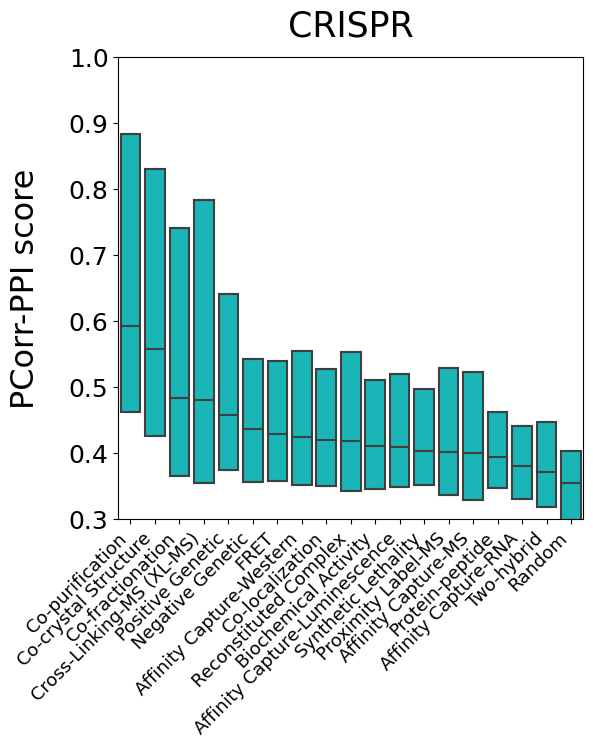

100%|██████████| 28/28 [00:00<00:00, 97.15it/s] 


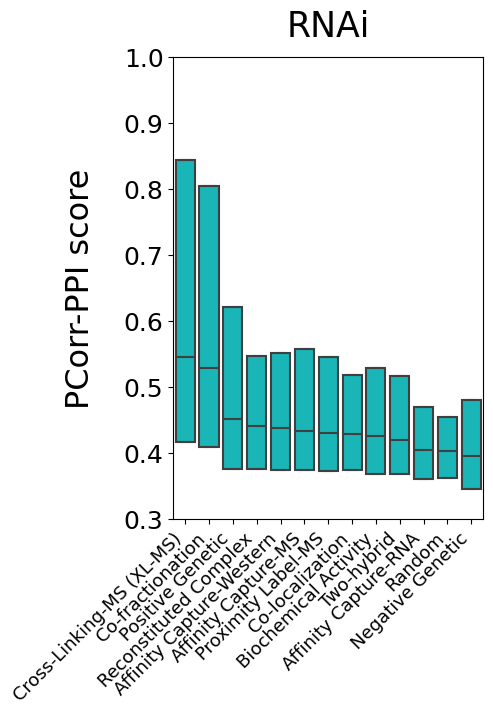

In [18]:
r_biogrid_key_ex = pickle.load(open('PCorr_PPI_datasets/r_biogrid_key_ex.pkl', 'rb'))
r_randombiogrid_key = pickle.load(open('PCorr_PPI_datasets/r_randombiogrid_key.pkl', 'rb'))

for ge_key in ['CRISPR','RNAi']:
    r_randombiogrid = r_randombiogrid_key[ge_key]

    data_plot = pd.DataFrame()
    data_median = pd.DataFrame()
    for ex in tqdm(r_biogrid_key_ex.keys()):
        try:
            r_biogrid = r_biogrid_key_ex[ex][ge_key]
            score_lst = list(r_biogrid['y_probs'])
            if len(score_lst) >= 1000:
                ppis = set(r_biogrid.index)
                try:
                    ppis_ex_key[ge_key][ex] = ppis
                except:
                    ppis_ex_key[ge_key] = {}
                    ppis_ex_key[ge_key][ex] = ppis

                df = pd.DataFrame()
                df['score'] = score_lst
                df['experiment'] = [ex]*len(r_biogrid)
                data_plot = pd.concat([data_plot, df],axis=0).reset_index(drop=True)
                data_median.loc[ex,'median'] = np.median(score_lst)
        except:
            pass
    df_bg = pd.DataFrame()
    df_bg['score'] = list(r_randombiogrid['y_probs'])
    df_bg['experiment'] = ['Random'] * len(df_bg)

    data_plot = pd.concat([data_plot, df_bg], axis=0).reset_index(drop=True)

    data_plot_bg = data_plot[data_plot['experiment']=='Random']
    data_median.loc['Random', 'median'] = np.median(data_plot_bg['score'])
    data_median = data_median.sort_values(by='median', ascending=False)
    order = list(data_median.index)

    data_plot['experiment'] = pd.Categorical(data_plot['experiment'], categories=order, ordered=True)

    # 按照指定顺序排序
    data_plot = data_plot.sort_values(by='experiment')

    plt.figure(figsize=(len(set(data_plot['experiment']))//3, 6))
    sns.boxplot(x='experiment', y='score', data=data_plot, dodge=False, showfliers=False,color='#00ced1',whis=False)
    plt.yticks(ha='right', fontsize=18)
    plt.xticks(ha='right', fontsize=13, rotation=45)
    plt.ylabel('PCorr-PPI score', fontsize=23,labelpad=20)
    plt.xlabel('', fontsize=23)
    plt.ylim(0.3,1)
    plt.title(ge_key, fontsize=25, pad=15)
    plt.show()